<a href="https://colab.research.google.com/github/flaviorv/ai_model_lifecycle/blob/main/flavio_varoto_DR1_AT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Installing repo and a lib to generate synthetic data

In [2]:
!pip install ucimlrepo
!pip install imbalanced-learn

###Imports

In [3]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import pandas as pd

###Get data

In [4]:
# loading Diabetes Health Indicators dataset
dhi = fetch_ucirepo(id=891)

pd.set_option('display.max_colwidth', None)
print('Variable Information:')
display(dhi.variables)

Variable Information:


,name,role,type,demographic,description,units,missing_values
0,ID,ID,Integer,None,Patient ID,None,no
1,Diabetes_binary,Target,Binary,None,0 = no diabetes 1 = prediabetes or diabetes,None,no
2,HighBP,Feature,Binary,None,0 = no high BP 1 = high BP,None,no
3,HighChol,Feature,Binary,None,0 = no high cholesterol 1 = high cholesterol,None,no
4,CholCheck,Feature,Binary,None,0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years,None,no
5,BMI,Feature,Integer,None,Body Mass Index,None,no
6,Smoker,Feature,Binary,None,Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes,None,no
7,Stroke,Feature,Binary,None,(Ever told) you had a stroke. 0 = no 1 = yes,None,no
8,HeartDiseaseorAttack,Feature,Binary,None,coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes,None,no
9,PhysActivity,Feature,Binary,None,physical activity in past 30 days - not including job 0 = no 1 = yes,None,no


###Feature selection and df separation between features and target

In [5]:
# manual feature selection and features and target separation
x = dhi.data.features.drop(columns=['Education', 'Income', 'NoDocbcCost', 'AnyHealthcare'])
y = dhi.data.targets

# separating feature names and target name
feature_names = list(x.columns)
target_name = y.columns[0]

print('Target name:', target_name)
print('Feature names:', feature_names)
print('Target count:\n', y.value_counts())

Target name: Diabetes_binary
Feature names: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age']
Target count:
 Diabetes_binary
0                  218334
1                   35346
Name: count, dtype: int64


###Train and test split

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.20, stratify=y, random_state=42)
# Showing stratification
print('Diabetic target proportion on the train:', ytrain.value_counts(normalize=True))
print('Diabetic target proportion on the test:', ytest.value_counts(normalize=True))

Diabetic target proportion on the train: Diabetes_binary
0                  0.860666
1                  0.139334
Name: proportion, dtype: float64
Diabetic target proportion on the test: Diabetes_binary
0                  0.860671
1                  0.139329
Name: proportion, dtype: float64


###Normalization

In [ ]:
# Selecting features to scaling
numerics = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age']
scaler = MinMaxScaler()
print(xtrain[numerics])
# Scaling only the numerics
x_train_scaled = xtrain
x_test_scaled = xtest
x_train_scaled[numerics] = scaler.fit_transform(xtrain[numerics])
x_test_scaled[numerics] = scaler.transform(xtest[numerics])
print(x_train_scaled[numerics])

        BMI  GenHlth  MentHlth  PhysHlth  Age
153147   28        2         0         0    2
176137   23        2         0         0   13
175578   29        1         0         0    9
177887   39        4         0         0    7
182143   16        5        30        30    7
...     ...      ...       ...       ...  ...
208398   25        4         0         0   10
106221   25        2         0         1    9
169035   18        4        30        30    7
49036    26        3         0         0    8
206060   31        4         0         5    8

[202944 rows x 5 columns]
             BMI  GenHlth  MentHlth  PhysHlth       Age
153147  0.186047     0.25       0.0  0.000000  0.083333
176137  0.127907     0.25       0.0  0.000000  1.000000
175578  0.197674     0.00       0.0  0.000000  0.666667
177887  0.313953     0.75       0.0  0.000000  0.500000
182143  0.046512     1.00       1.0  1.000000  0.500000
...          ...      ...       ...       ...       ...
208398  0.151163     0.75    

###First Training and evaluation - KNN

In [ ]:
# Training the model with different number of neighbors
n_neighbors = [2, 5, 80]
for n in n_neighbors:
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(x_train_scaled, ytrain['Diabetes_binary'])
  ypredicted = knn.predict(x_test_scaled)
  print(f'Neighbors: {n}')
  print(classification_report(ytest, ypredicted))

Neighbors: 2
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     43667
           1       0.38      0.11      0.17      7069

    accuracy                           0.85     50736
   macro avg       0.62      0.54      0.54     50736
weighted avg       0.80      0.85      0.81     50736

Neighbors: 5
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     43667
           1       0.39      0.21      0.27      7069

    accuracy                           0.84     50736
   macro avg       0.64      0.58      0.59     50736
weighted avg       0.81      0.84      0.82     50736

Neighbors: 80
              precision    recall  f1-score   support

           0       0.87      0.99      0.93     43667
           1       0.55      0.07      0.13      7069

    accuracy                           0.86     50736
   macro avg       0.71      0.53      0.53     50736
weighted avg       0.82      0.86 

###Balancing the train data

In [ ]:
smote = SMOTE(k_neighbors=2, random_state=42)
xbalanced, ybalanced = smote.fit_resample(x_train_scaled, ytrain)
print(ybalanced.value_counts())

Diabetes_binary
0                  174667
1                  174667
Name: count, dtype: int64


###Retraining KNN with balanced train set

In [ ]:
n_neighbors = [5, 50, 100, 250]
for n in n_neighbors:
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(xbalanced, ybalanced['Diabetes_binary'])
  ypredicted = knn.predict(xtest)
  print(f'Neighbors: {n}')
  print(classification_report(ytest, ypredicted))

Neighbors: 5
              precision    recall  f1-score   support

           0       0.91      0.77      0.84     43667
           1       0.28      0.56      0.37      7069

    accuracy                           0.74     50736
   macro avg       0.60      0.66      0.60     50736
weighted avg       0.83      0.74      0.77     50736

Neighbors: 50
              precision    recall  f1-score   support

           0       0.95      0.67      0.79     43667
           1       0.28      0.77      0.41      7069

    accuracy                           0.69     50736
   macro avg       0.61      0.72      0.60     50736
weighted avg       0.85      0.69      0.73     50736

Neighbors: 100
              precision    recall  f1-score   support

           0       0.95      0.67      0.78     43667
           1       0.28      0.79      0.41      7069

    accuracy                           0.68     50736
   macro avg       0.62      0.73      0.60     50736
weighted avg       0.86      0.6

###KNN Cross Validation

In [ ]:
# The pipeline inside the cross_validate ensures that the val fold created by the cross_val_score does not contain synthetic data.
# It aslo ensures that the val fold not fit the scaling. This way, there is no data leackage
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(k_neighbors=2, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=250))
])

score = cross_validate(
    pipeline, xtrain, ytrain['Diabetes_binary'],
    scoring=['recall', 'precision', 'accuracy', 'f1'],
    cv=5, return_train_score=True
)

print('Cross validation with 5 folds')
metrics = ['train_precision', 'test_precision', 'train_recall', 'test_recall', 'train_f1', 'test_f1', 'train_accuracy', 'test_accuracy']
score = pd.DataFrame(score)
display(score[metrics])

Cross validation with 5 folds


,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_accuracy,test_accuracy
0,0.284201,0.280091,0.808859,0.804067,0.420615,0.415460,0.689508,0.684767
1,0.282607,0.276950,0.819114,0.802299,0.420229,0.411762,0.685073,0.680628
2,0.283680,0.276974,0.814685,0.791549,0.420825,0.410357,0.687555,0.683018
3,0.283114,0.278676,0.813448,0.798091,0.420037,0.413105,0.687019,0.684003
4,0.283564,0.283002,0.808549,0.804067,0.419875,0.418654,0.688684,0.688874


###Best KNN

In [ ]:
ct = ColumnTransformer([
    ('scaler', MinMaxScaler(), numerics)
], remainder='passthrough')

pipeline = Pipeline([
    ('scaling', ct),
    ('smote', SMOTE(k_neighbors=2, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=250))
])

best_knn = pipeline.fit(xtrain, ytrain['Diabetes_binary'])

###KNN ROC curve and AUC

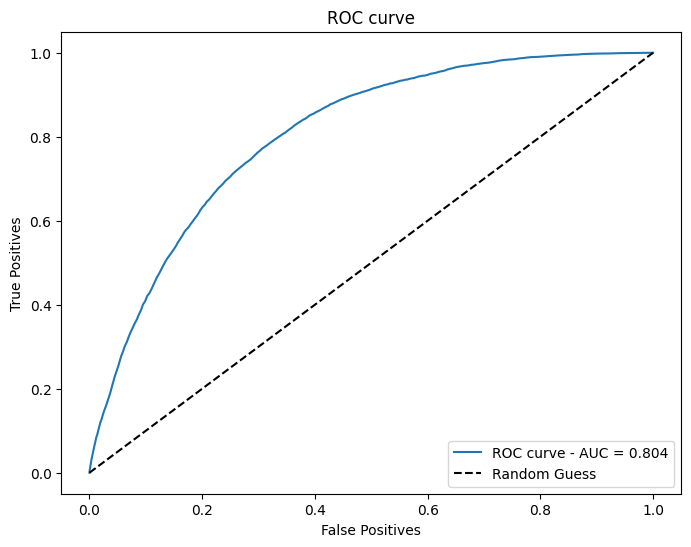

In [ ]:
# Probabilities for each class
knn_prob = best_knn.predict_proba(xtest)[:, 1]

fpr, tpr, knn_thresholds = roc_curve(ytest, knn_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve - AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positives')
plt.ylabel('True Positives')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

###Adjusting KNN threshold

              precision    recall  f1-score   support

           0      0.972     0.511     0.670     43667
           1      0.231     0.908     0.369      7069

    accuracy                          0.567     50736
   macro avg      0.601     0.710     0.519     50736
weighted avg      0.869     0.567     0.628     50736



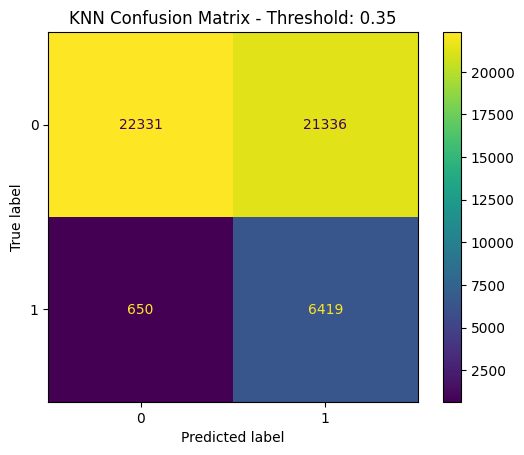

In [ ]:
threshold = 0.35
knn_custom_pred = (knn_prob >= threshold).astype(int)
print(classification_report(ytest, knn_custom_pred, digits=3))

cm = confusion_matrix(ytest, knn_custom_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=[0, 1])
cmd.plot()
plt.title(f'KNN Confusion Matrix - Threshold: {threshold}')
plt.show()

###New model

In [ ]:
#Random Forest model
rfpipeline = Pipeline([
    ('balancer', RandomUnderSampler()),
    ('model', RandomForestClassifier())
])

rfscore = cross_validate(
    rfpipeline, xtrain, ytrain['Diabetes_binary'],
    scoring=['recall', 'precision', 'accuracy', 'f1'],
    cv=5, return_train_score=True
)

rfscore = pd.DataFrame(rfscore)
metrics = ['train_precision', 'test_precision', 'train_recall', 'test_recall', 'train_f1', 'test_f1', 'train_accuracy', 'test_accuracy']
display(rfscore[metrics])

,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_accuracy,test_accuracy
0,0.370347,0.278996,0.972902,0.760566,0.536478,0.408239,0.765748,0.692799
1,0.373460,0.284485,0.972593,0.760035,0.539688,0.414006,0.768828,0.700239
2,0.375036,0.287258,0.972282,0.761315,0.541284,0.417127,0.770392,0.703516
3,0.373387,0.284507,0.972017,0.762023,0.539523,0.414323,0.768821,0.699796
4,0.374466,0.285467,0.972018,0.757206,0.540649,0.414621,0.769858,0.702104


###Comparing models test recall and precision

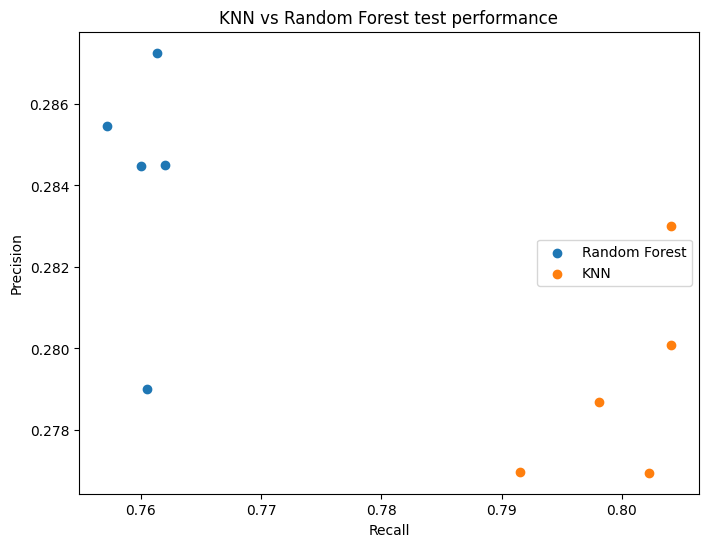

In [ ]:
rf_sorted = rfscore.sort_values(by='test_recall')
knn_sorted = score.sort_values(by='test_recall')


plt.figure(figsize=(8,6))
plt.scatter(rf_sorted['test_recall'], rf_sorted['test_precision'], label='Random Forest')
plt.scatter(knn_sorted['test_recall'], knn_sorted['test_precision'], label='KNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='right')
plt.title('KNN vs Random Forest test performance')
plt.show()

###Adjusting Random Forest hyperparameter with GridSearch

In [ ]:
scoring = {'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'accuracy': 'accuracy'}

rfpipeline = Pipeline([
    ('resampler', RandomUnderSampler(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=2, criterion='entropy'))
])

gridparams = {
    'rf__n_estimators': [22, 25, 28],
    'rf__max_depth': [6, 7, 8],
    'rf__min_samples_split': [5, 6, 7],
}

grid = GridSearchCV(
    rfpipeline, gridparams, cv=5,
    scoring=scoring, refit='recall',
    n_jobs=-1, verbose=2
)

grid.fit(xtrain, ytrain['Diabetes_binary'])

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('resampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(criterion='entropy',
                                                               n_jobs=2,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [6, 7, 8],
                         'rf__min_samples_split': [5, 6, 7],
                         'rf__n_estimators': [22, 25, 28]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'},
             verbose=2)

In [ ]:
best_rf_pipeline = Pipeline(steps=[
    ('resampler', RandomUnderSampler(random_state=42)),
    ('rf', RandomForestClassifier(criterion='entropy', max_depth=7, min_samples_split=6, n_estimators=25, n_jobs=2, random_state=42))
])

best_rf_score = cross_validate(
    best_rf_pipeline, xtrain, ytrain['Diabetes_binary'],
    scoring=['recall', 'precision', 'accuracy', 'f1'],
    cv=5, return_train_score=True
)

best_rf_score = pd.DataFrame(best_rf_score)
metrics = ['train_precision', 'test_precision', 'train_recall', 'test_recall', 'train_f1', 'test_f1', 'train_accuracy', 'test_accuracy']
display(best_rf_score[metrics])

,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_accuracy,test_accuracy
0,0.298716,0.297150,0.800283,0.800177,0.435046,0.433367,0.710388,0.708468
1,0.300862,0.297263,0.799487,0.793280,0.437198,0.432469,0.713196,0.709921
2,0.302816,0.299104,0.797754,0.784830,0.438995,0.433137,0.715913,0.713740
3,0.300176,0.296779,0.800937,0.796676,0.436689,0.432458,0.712094,0.708616
4,0.300257,0.302650,0.796526,0.793634,0.436116,0.438196,0.713001,0.716468


###Undersampling and fit with the best hyper-parameters

In [8]:
undersampler = RandomUnderSampler(random_state=42)
xundersampled, yundersampled = undersampler.fit_resample(xtrain, ytrain)

rf = RandomForestClassifier(criterion='entropy', max_depth=7, min_samples_split=6, n_estimators=25, n_jobs=2, random_state=42)
rf.fit(xundersampled, yundersampled['Diabetes_binary'])

RandomForestClassifier(criterion='entropy', max_depth=7, min_samples_split=6,
                       n_estimators=25, n_jobs=2, random_state=42)

###Adjusted Random Forest Confusion Matrix

              precision    recall  f1-score   support

           0    0.95272   0.69547   0.80402     43667
           1    0.29491   0.78682   0.42902      7069

    accuracy                        0.70820     50736
   macro avg    0.62382   0.74114   0.61652     50736
weighted avg    0.86107   0.70820   0.75177     50736



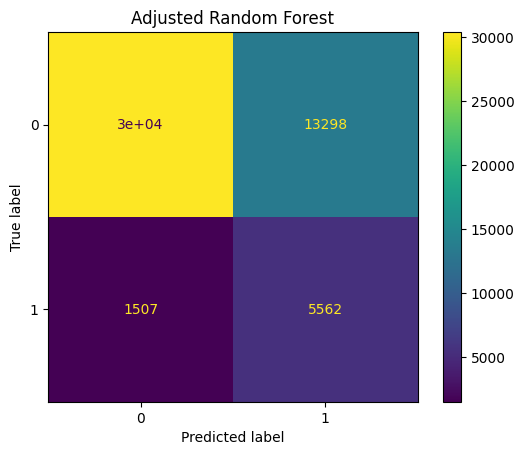

In [ ]:
ypred = rf.predict(xtest)
cm = confusion_matrix(ytest, ypred)

print(classification_report(ytest, ypred, digits=5))
cmd = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=[0, 1])
cmd.plot()
plt.title('Adjusted Random Forest')
plt.show()

###Random Forest ROC curve to get the best threshold according to our objectives

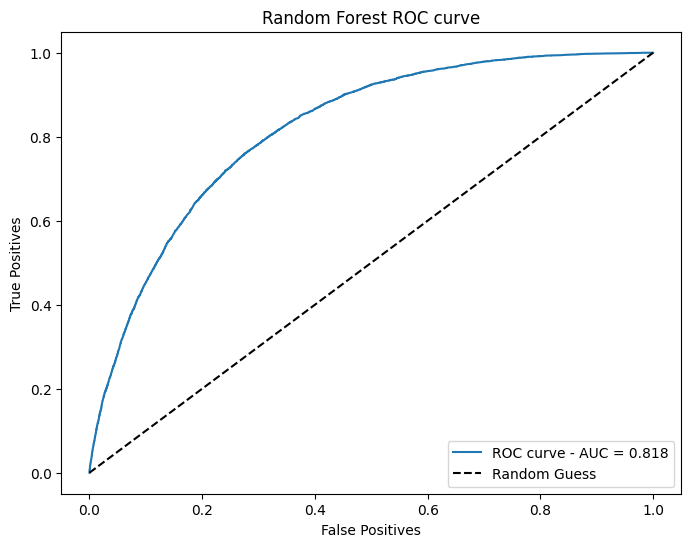

In [12]:
# Probabilities of each class
yprob = rf.predict_proba(xtest)[:, 1]

fpr, tpr, thresholds = roc_curve(ytest, yprob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve - AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positives')
plt.ylabel('True Positives')
plt.title('Random Forest ROC curve')
plt.legend(loc='lower right')
plt.show()

###Adjusting the threshold to get the max recall

              precision    recall  f1-score   support

           0    1.00000   0.00053   0.00105     43667
           1    0.13939   1.00000   0.24468      7069

    accuracy                        0.13978     50736
   macro avg    0.56970   0.50026   0.12287     50736
weighted avg    0.88009   0.13978   0.03500     50736



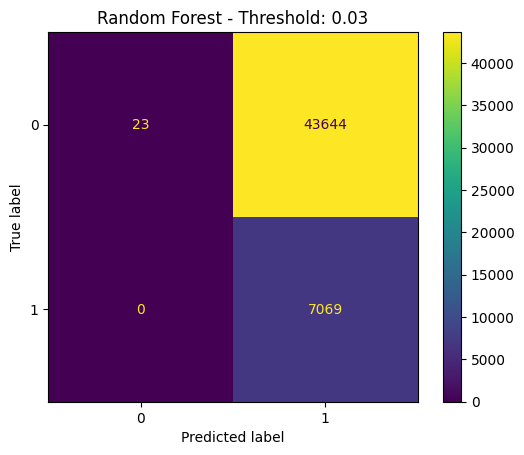

In [13]:
threshold = 0.03
custom_pred = (yprob >= threshold).astype(int)

cm = confusion_matrix(ytest, custom_pred)

print(classification_report(ytest, custom_pred, digits=5))
cmd = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=[0, 1])
cmd.plot()
plt.title(f'Random Forest - Threshold: {threshold}')
plt.show()

###Adjusting the threshold to get tradeoff between recall and precision ( but keeping high recall )

              precision    recall  f1-score   support

           0      0.975     0.509     0.669     43667
           1      0.232     0.919     0.371      7069

    accuracy                          0.566     50736
   macro avg      0.604     0.714     0.520     50736
weighted avg      0.871     0.566     0.627     50736



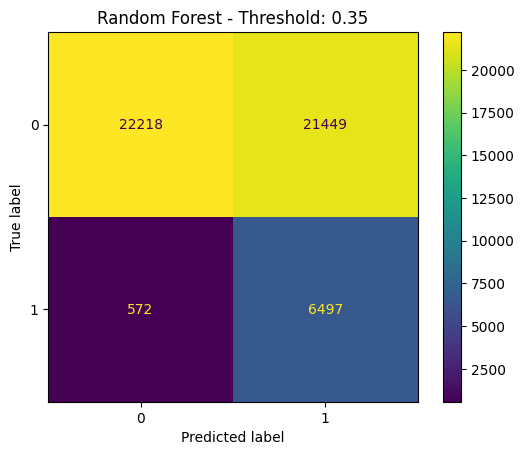

In [14]:
threshold = 0.35
custom_pred = (yprob >= threshold).astype(int)

print(classification_report(ytest, custom_pred, digits=3))
cm = confusion_matrix(ytest, custom_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=[0, 1])
cmd.plot()
plt.title(f'Random Forest - Threshold: {threshold}')
plt.show()

Comparing previous and current Random Forest model

In [15]:
previous_rf = RandomForestClassifier()
previous_rf.fit(xundersampled, yundersampled['Diabetes_binary'])
previous_rf_pred = previous_rf.predict(xtest)
previous_rf_score = classification_report(ytest, previous_rf_pred, output_dict=True)
previous_rf_score_df = pd.DataFrame(previous_rf_score).transpose()

current_rf_score = classification_report(ytest, custom_pred, output_dict=True)
current_rf_score_df = pd.DataFrame(current_rf_score).transpose()

Previous vs Current - Random Forest models


,previous_recall,current_recall,previous_precision,current_precision,previous_f1-score,current_f1-score
0,0.691781,0.508805,0.945566,0.974901,0.799005,0.668643
1,0.753996,0.919083,0.283677,0.232484,0.412252,0.371098
accuracy,0.700449,0.565969,0.700449,0.565969,0.700449,0.565969
macro avg,0.722889,0.713944,0.614621,0.603693,0.605629,0.519870
weighted avg,0.700449,0.565969,0.853346,0.871461,0.745119,0.627186


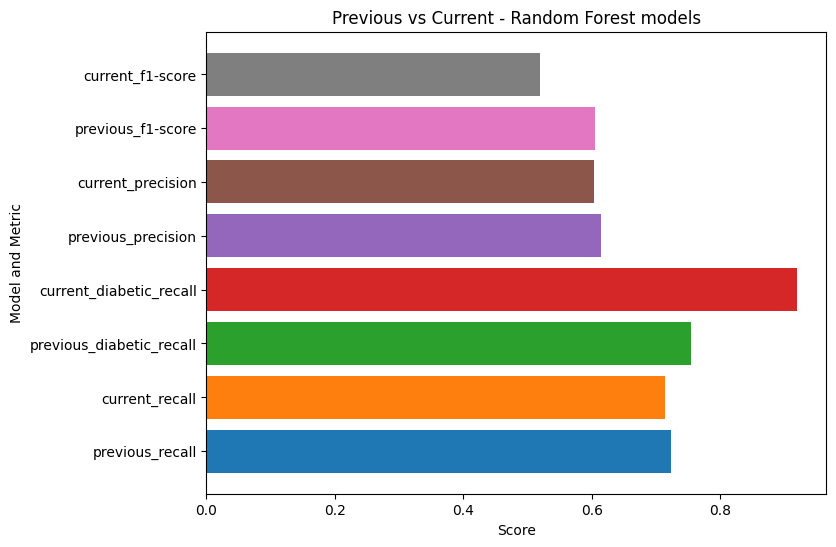

In [17]:
comparison = pd.DataFrame()
metrics = ['recall', 'precision', 'f1-score']
plt.figure(figsize=(8,6))
for metric in metrics:
  comparison[f'previous_{metric}'] = previous_rf_score_df[metric]
  comparison[f'current_{metric}'] = current_rf_score_df[metric]
  plt.barh(f'previous_{metric}', previous_rf_score_df[metric]['macro avg'])
  plt.barh(f'current_{metric}', current_rf_score_df[metric]['macro avg'])
  if metric == 'recall':
    plt.barh(f'previous_diabetic_{metric}', previous_rf_score_df[metric]['1'])
    plt.barh(f'current_diabetic_{metric}', current_rf_score_df[metric]['1'])

print('Previous vs Current - Random Forest models')
display(comparison)

plt.bar
plt.ylabel('Model and Metric')
plt.xlabel('Score')
plt.title('Previous vs Current - Random Forest models')
plt.show()